* Plot radio dynamic spectra from ORFEES and NenuFAR.
* Plot timeseries of STIX, ORFEES, and NenuFAR.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from radiospectra.spectrogram2 import Spectrogram
from stixpy.net.client import STIXClient  # This registers the STIX client with Fido
from stixpy.product import Product
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.collections import QuadMesh
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00' # use precise epoch
try: mdates.set_epoch('1970-01-01T00:00:00')
except: pass

# import time, os

data_dir = '/home/mnedal/data'

In [3]:
mydate = '2025-03-25'

year, month, day = mydate.split('-')

In [4]:
files = glob.glob(f'{data_dir}/int_orf{year}{month}{day}_*.fts')

orfees = fits.open(files[0])
orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
orfees_data = orfees_i.T

orfees_time_str = orfees[0].header['DATE-OBS']
orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)])*u.MHz

In [5]:
# convert ORFEES data to a DataFrame and plot it to determine the quiet period, which will be divided by later.
df_orfees = pd.DataFrame(data=orfees_data, index=orfees_times, columns=orfees_freqs.value.flatten())
df_orfees.index = [t.datetime for t in df_orfees.index]
df_orfees.head(3)

144.130005   144.520004   144.910004   145.300003   \
2025-03-25 06:56:06.740    38.740002    49.170002    55.987503    53.974998   
2025-03-25 06:56:06.840    40.230003    50.660000    53.490002    52.929996   
2025-03-25 06:56:06.940    47.680000    55.130001    54.782501    53.974998   

                         145.690002   146.960007   148.089996   148.429993   \
2025-03-25 06:56:06.740    55.317501       52.805    53.143330    54.192501   
2025-03-25 06:56:06.840    54.639999       53.625    53.639999    53.817501   
2025-03-25 06:56:06.940    55.472500       54.430    53.639999    54.192501   

                         148.820007   149.210007   ...  990.729980   \
2025-03-25 06:56:06.740    55.035000    54.482498  ...    42.108749   
2025-03-25 06:56:06.840    53.162498    53.737503  ...    42.108749   
2025-03-25 06:56:06.940    53.910000    54.850002  ...    42.108749   

                         992.289978   993.859985   995.419983   996.979980   \
2025-03-25 06:56:06.740    41.434372    46.627499    44.325623    40.367504   
2025-03-25 06:56:06.840    42.340622    46.627499    44.325623    41.341877   
2025-03-25 06:56:06.940    42.787498    46.627499    41.891243    39.887505   

                         998.539978   1000.109985  1001.669983  1003.229980  \
2025-03-25 06:56:06.740    47.371876    46.206249    51.374996    53.906246   
2025-03-25 06:56:06.840    47.371876    47.474998    51.374996    53.906246   
2025-03-25 06:56:06.940    47.371876    47.493752    52.293747    53.906246   

                         1004.700012  
2025-03-25 06:56:06.740    70.457146  
2025-03-25 06:56:06.840    70.457146  
2025-03-25 06:56:06.940    70.457146  

[3 rows x 998 columns]

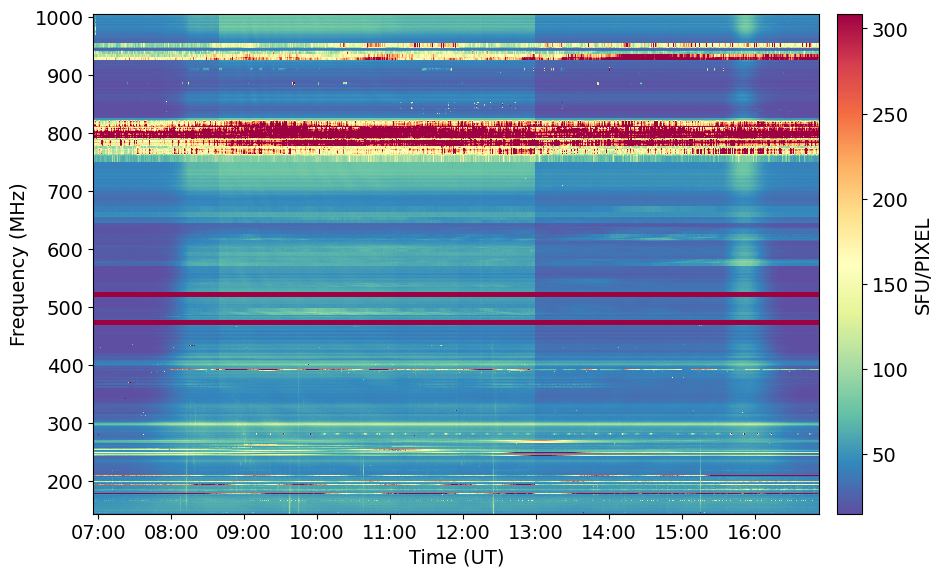

In [26]:
v_range = np.nanpercentile(df_orfees, [1,96])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees.index, df_orfees.columns, df_orfees.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

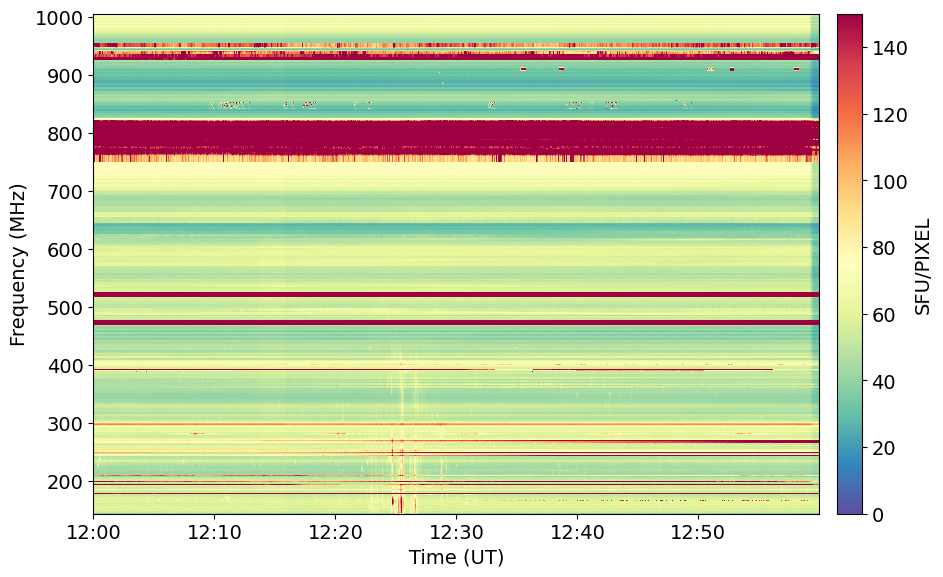

In [79]:
start_time = pd.to_datetime('2025-03-25T12:00:00')
end_time   = pd.to_datetime('2025-03-25T13:00:00')

start_nearest = df_orfees.index.asof(start_time)
end_nearest   = df_orfees.index.asof(end_time)

df_sliced = df_orfees.loc[start_nearest:end_nearest]

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_sliced.index, df_sliced.columns, df_sliced.T,
                   vmin=0, vmax=150, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [89]:
bkg_removal_method = 1

if bkg_removal_method==1:
    print('Find the exact or earlier timestamps, and slice at this window')
    start_time = pd.to_datetime('2025-03-25T07:00:00')
    end_time   = pd.to_datetime('2025-03-25T07:15:00')
    
    start_nearest = df_orfees.index.asof(start_time)
    end_nearest   = df_orfees.index.asof(end_time)
    
    subdf = df_orfees.loc[start_nearest:end_nearest]
    df_sliced = subdf.mean(axis=0)
    # print(start_nearest, end_nearest, sep='\n')
    print('Remove the background by dividing the data by the quiet background')
    df_orfees_nobkg = df_orfees/df_sliced

elif bkg_removal_method==2:
    print('### Find the nearest row to a single timestamp')
    start_time = pd.to_datetime('2025-03-25T07:00:00')
    
    nearest_idx = df_orfees.index.get_indexer([start_time], method='nearest')[0]
    df_sliced = df_orfees.iloc[nearest_idx]
    
    actual_time = df_orfees.index[nearest_idx]
    # print(actual_time)
    print('Remove the background by dividing the data by the quiet background')
    df_orfees_nobkg = df_orfees/df_sliced

Find the exact or earlier timestamps, and slice at this window
Remove the background by dividing the data by the quiet background


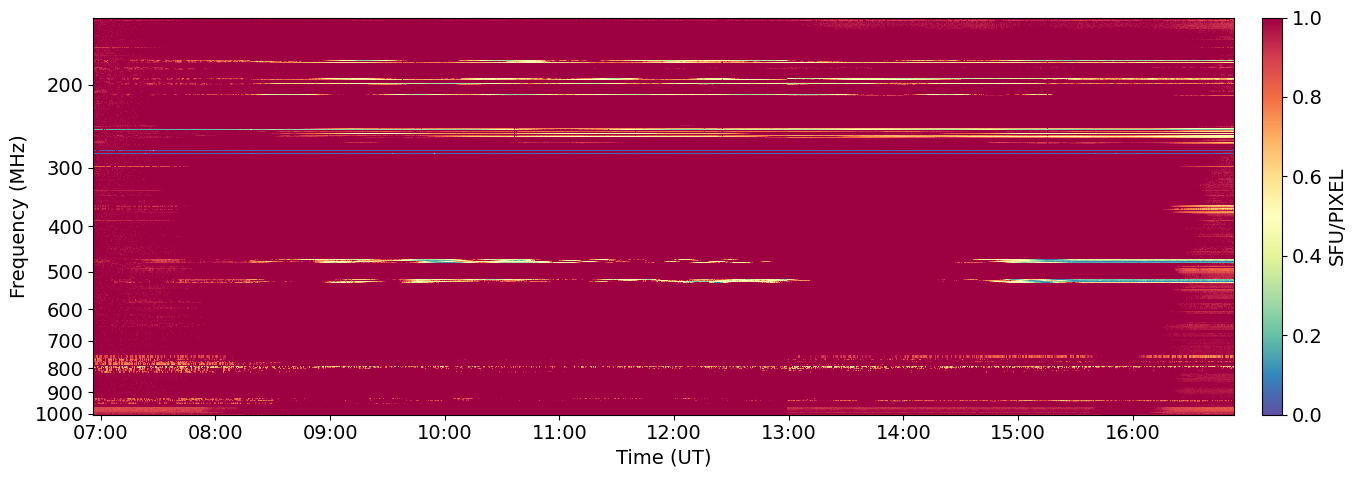

In [91]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_nobkg.index, df_orfees_nobkg.columns, df_orfees_nobkg.T,
                   # vmin=v_range[0], vmax=v_range[1],
                   vmin=0, vmax=1,
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [6]:
df_orfees_1s = df_orfees.resample('1S').mean()

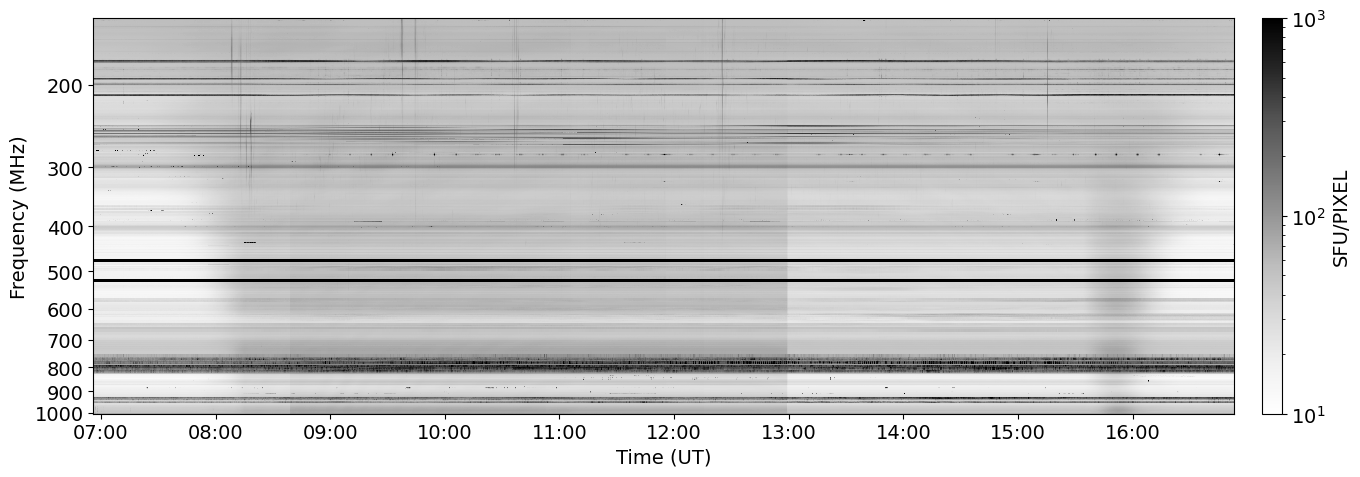

In [118]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
                   norm=LogNorm(vmin=1e1, vmax=1e3),
                   # norm=LogNorm(vmin=np.nanpercentile(df_orfees_1s, 0), vmax=np.nanpercentile(df_orfees_1s, 90)),
                   cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

## Load NenuFAR data

In [157]:
nenufar_files = sorted(glob.glob('/home/mnedal/outputs/data/*'))
nenufar_files

['/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeII.pkl',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G1.pkl',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G2.npz',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G3.npz',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G4.pkl']

In [158]:
df_nenufar = pd.read_pickle(nenufar_files[4])

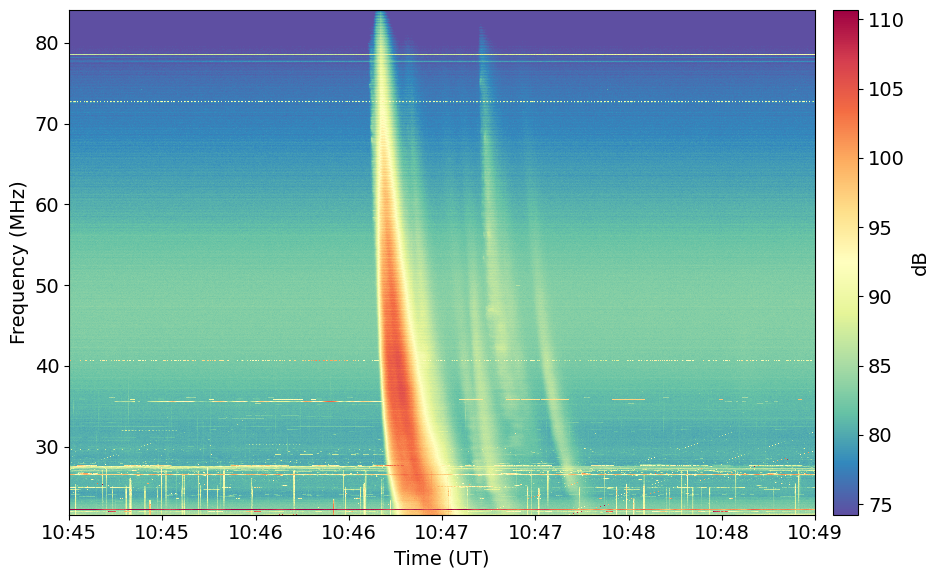

In [129]:
v_range = np.nanpercentile(df_nenufar, [7, 99.97])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [132]:
# slice nenufar to match orfees
start_time = pd.to_datetime(df_nenufar.index[0])
end_time   = pd.to_datetime(df_nenufar.index[-1])

start_nearest = df_orfees.index.asof(start_time)
end_nearest   = df_orfees.index.asof(end_time)

subdf_orfees = df_orfees.loc[start_nearest:end_nearest]
subdf_orfees.index[0], subdf_orfees.index[-1]

(Timestamp('2025-03-25 10:44:59.940000'),
 Timestamp('2025-03-25 10:48:59.940000'))

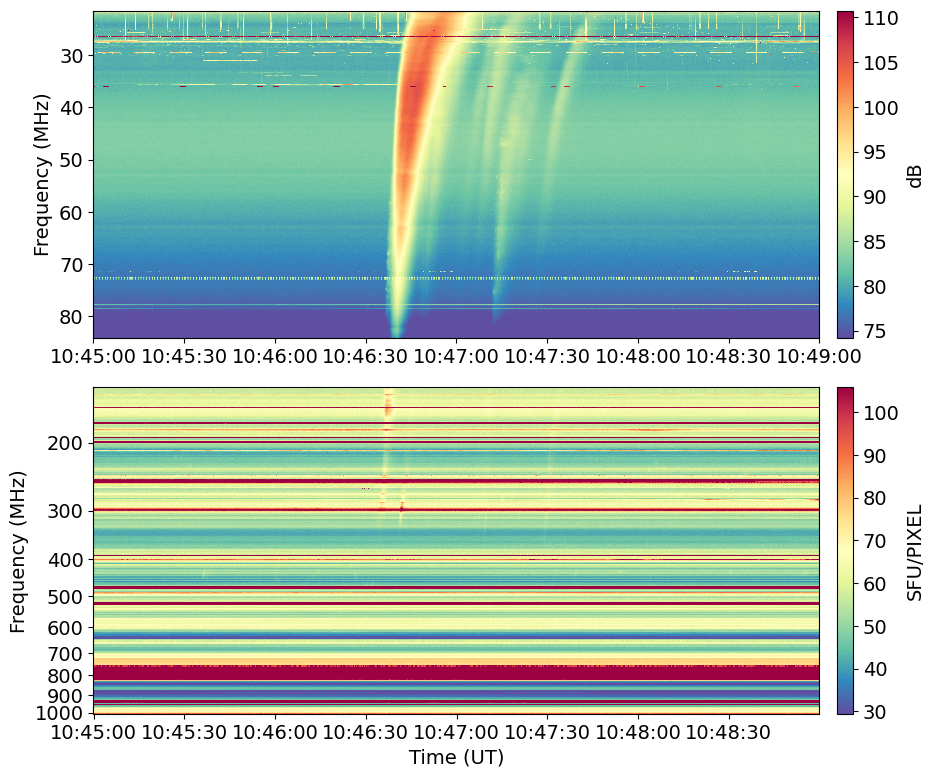

In [135]:
fig = plt.figure(figsize=[10,8])

v_range = np.nanpercentile(df_nenufar, [7, 99.97])
ax = fig.add_subplot(211)
pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

v_range = np.nanpercentile(subdf_orfees, [1, 90])
ax = fig.add_subplot(212)
pc = ax.pcolormesh(subdf_orfees.index, subdf_orfees.columns, subdf_orfees.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

fig.tight_layout()
plt.show()

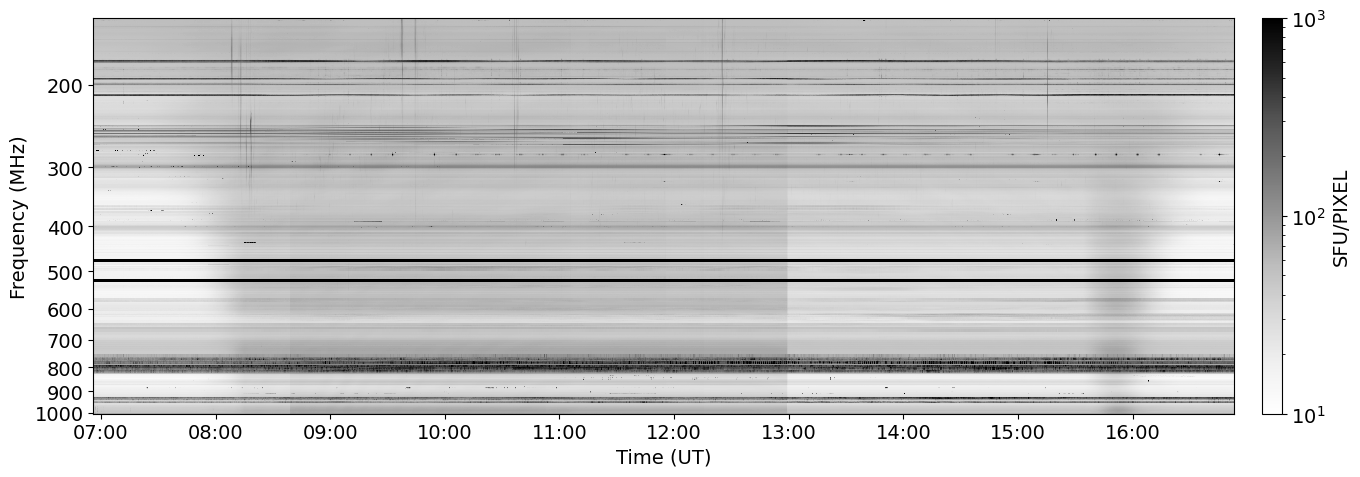

In [7]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
                   norm=LogNorm(vmin=1e1, vmax=1e3), cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

### Option 1: Use a single reference level (e.g., median of all values)

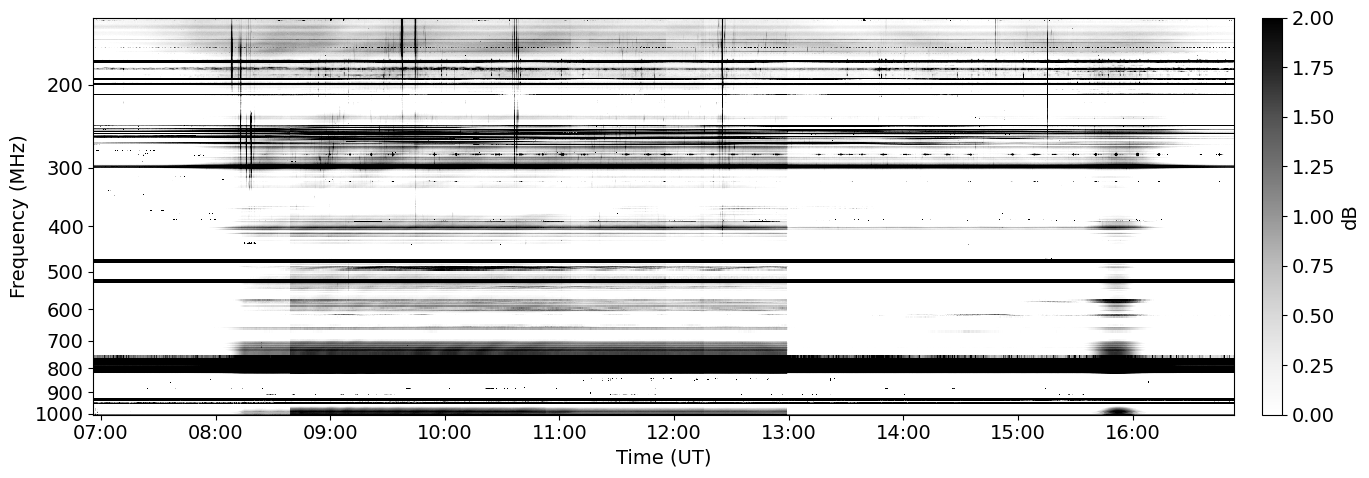

In [17]:
# Avoid log(0) or log of negative numbers
sfu_data_clipped = df_orfees_1s.clip(lower=1e-10)

# Global reference (e.g., median of entire dataset)
P_ref = sfu_data_clipped.median().median()

# Convert to dB
db_data = 10 * np.log10(sfu_data_clipped / P_ref)

# Clean up result
db_data.replace([-np.inf, np.inf], np.nan, inplace=True)

fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(db_data.index, db_data.columns, db_data.T,
                   vmin=0, vmax=2, cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

### Option 2: Use a reference per frequency (i.e., per column)

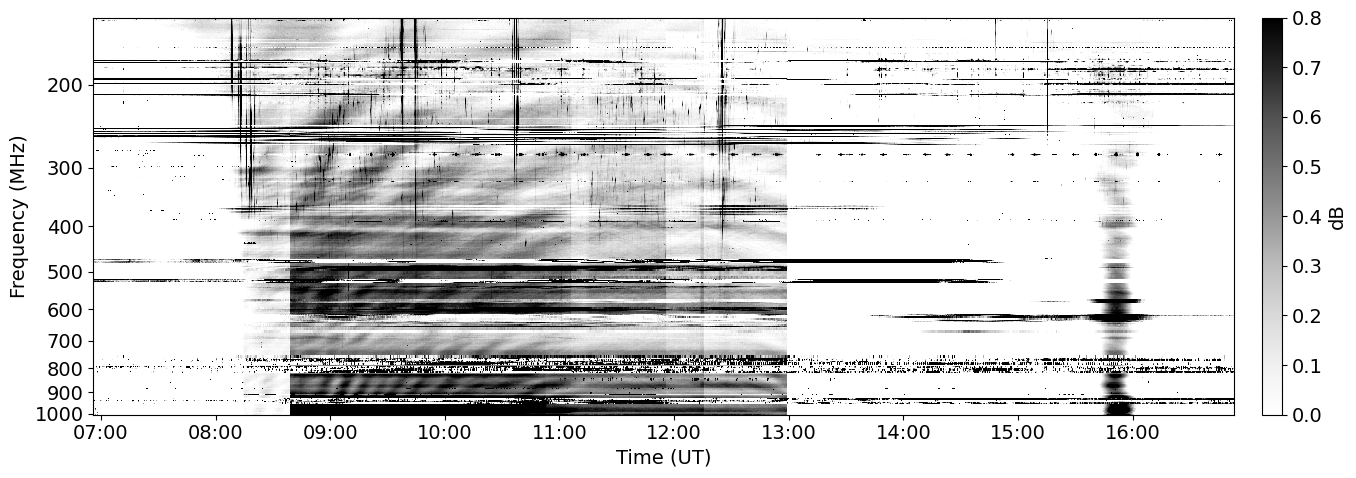

In [48]:
# Avoid log(0) or log of negative numbers
sfu_data_clipped = df_orfees_1s.clip(lower=1e-10)

# Column-wise (per frequency) reference: median per column
P_ref_per_freq = sfu_data_clipped.median(axis=0)  # Series of shape (num_columns,)

# Broadcasting across rows
db_data = 10 * np.log10(sfu_data_clipped.div(P_ref_per_freq, axis='columns'))

# Clean up result
db_data.replace([-np.inf, np.inf], np.nan, inplace=True)

fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(db_data.index, db_data.columns, db_data.T,
                   vmin=0, vmax=0.8, cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [20]:
# Downsample to 1-min resolution
df_orfees_1min = db_data.resample('1min').mean()

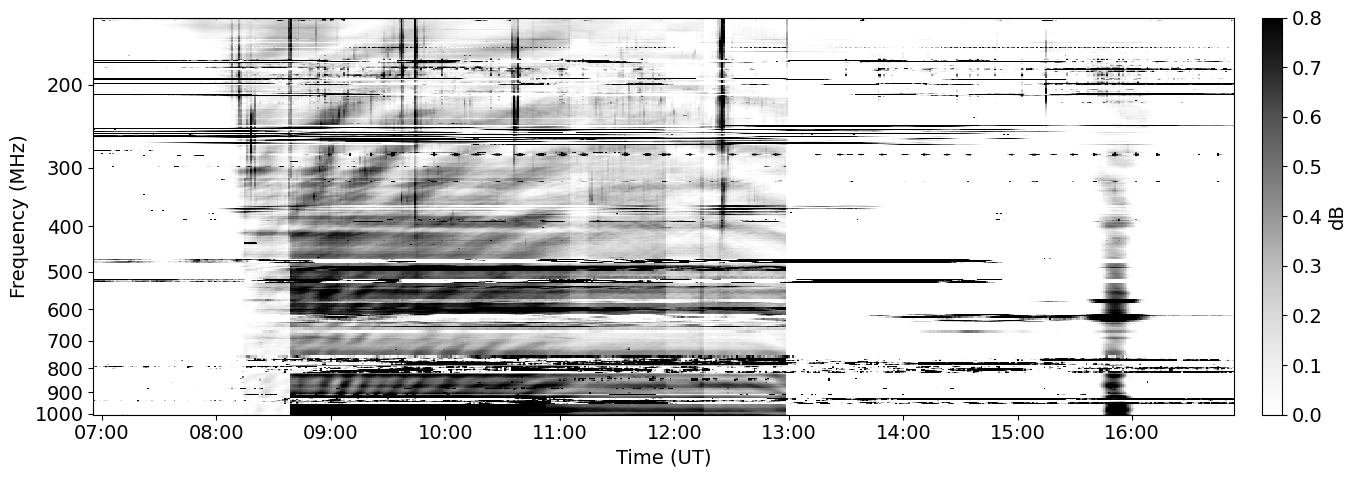

In [46]:
v_range = np.nanpercentile(df_orfees_1min, [50,96])

fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1min.index, df_orfees_1min.columns, df_orfees_1min.T,
                   # vmin=v_range[0], vmax=v_range[1],
                   vmin=0, vmax=0.8,
                   cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [62]:
np.median(np.diff(df_orfees.index)/np.timedelta64(1,'ms')).astype('int')

100

# Calibration Strategy

## 1. Downsample NenuFAR in time to match ORFEES time resolution

In [159]:
nenufar_cadence = np.median(np.diff(df_nenufar.index)/np.timedelta64(1,'ms'))
orfees_cadence = np.median(np.diff(df_orfees.index)/np.timedelta64(1,'ms'))#.astype('int')

print(f'Downsampling NenuFAR (dt = {nenufar_cadence} ms) to ORFEES cadence (dt = {orfees_cadence} ms)')

nenufar_db_down = df_nenufar.resample(f'{orfees_cadence}ms').mean()

assert np.median(np.diff(nenufar_db_down.index)/np.timedelta64(1,'ms')) == orfees_cadence, 'NenuFAR cadence does not match ORFEES cadence! Check the resampling.'

Downsampling NenuFAR (dt = 20.972 ms) to ORFEES cadence (dt = 100.0 ms)


## 2. Automatically detect quiet periods

In [138]:
def find_quiet_periods(df, window='10S', quant=0.1, std_thresh=None, use_median=True, iqr_multiplier=1.5):
    """
    Identify quiet times in a radio spectrogram based on low spectral variability.

    Parameters:
        df (pd.DataFrame): 2D data with shape (time, frequency) in SFU units.
        window (str): Rolling window size (e.g., '10S' for 10 seconds).
        quant (float): Quantile to use when estimating std_thresh if not provided.
        std_thresh (float or None): If provided, use this absolute threshold for std.
        use_median (bool): Whether to aggregate std across frequencies using median (more robust) or mean.
        iqr_multiplier (float): Multiplier for IQR if using automated thresholding based on boxplot rule.

    Returns:
        pd.DatetimeIndex: Timestamps of detected quiet periods.
    """
    rolling_std = df.rolling(window).std()
    agg_std = rolling_std.median(axis=1) if use_median else rolling_std.mean(axis=1)

    if std_thresh is None:
        Q1 = agg_std.quantile(0.25)
        Q3 = agg_std.quantile(0.75)
        IQR = Q3 - Q1
        std_thresh = Q1 - iqr_multiplier * IQR

    quiet_times = df.index[agg_std < std_thresh]
    return quiet_times

## 3. Apply to ORFEES and Convert SFU to dB

In [160]:
# Find quiet times in ORFEES
quiet_times_orf = find_quiet_periods(df_orfees, window='10S', iqr_multiplier=1.5)

# Compute median power level in quiet time — used as dB reference
orf_ref_sfu = df_orfees.loc[quiet_times_orf].median().median()

# Convert SFU to dB
orfees_db = 10 * np.log10(df_orfees / orf_ref_sfu)

In [145]:
# Downsample to 1-s resolution
df_orfees_1s = orfees_db.resample('1S').mean()

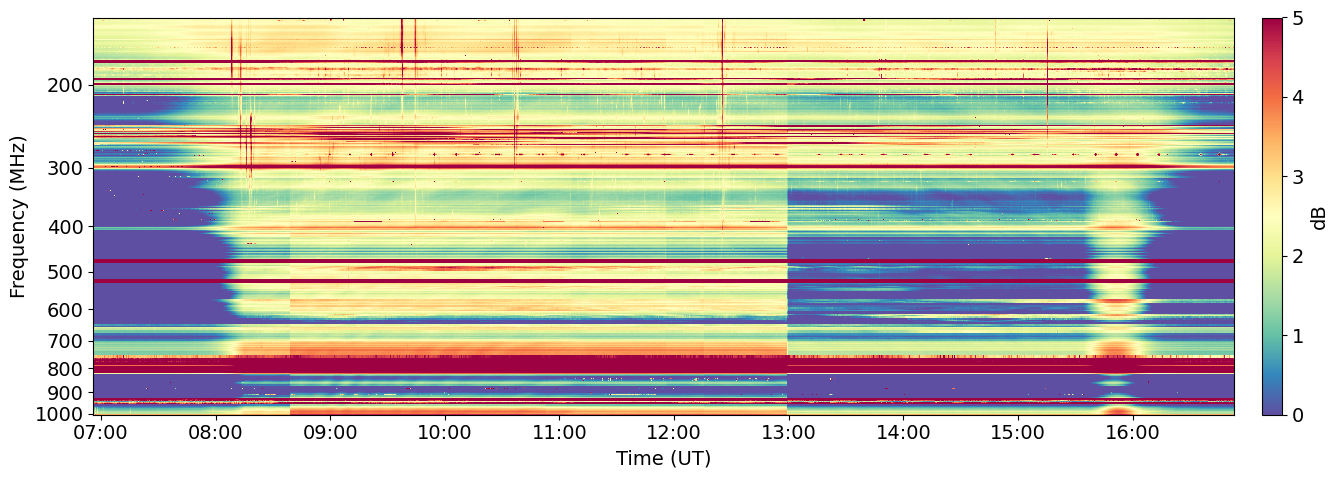

In [152]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
                   vmin=0, vmax=5, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [190]:
print('NenuFAR time range:', nenufar_db_down.index[0], 'to', nenufar_db_down.index[-1])
print('ORFEES time range:', orfees_db.index[0], 'to', orfees_db.index[-1])

NenuFAR time range: 2025-03-25 10:45:00 to 2025-03-25 10:49:00
ORFEES time range: 2025-03-25 06:56:06.740000 to 2025-03-25 16:53:15.840000


## 4. Slice ORFEES to match NenuFAR

In [191]:
start_time = pd.to_datetime(nenufar_db_down.index[0])
end_time   = pd.to_datetime(nenufar_db_down.index[-1])

start_nearest = orfees_db.index.asof(start_time)
end_nearest   = orfees_db.index.asof(end_time)

subdf_orfees_db = orfees_db.loc[start_nearest:end_nearest]
subdf_orfees_db.index[0], subdf_orfees_db.index[-1]

(Timestamp('2025-03-25 10:44:59.940000'),
 Timestamp('2025-03-25 10:48:59.940000'))

In [218]:
dt_start = np.abs(nenufar_db_down.index[0] - subdf_orfees_db.index[0]).total_seconds()*u.s.to('ms')
dt_end = np.abs(nenufar_db_down.index[-1] - subdf_orfees_db.index[-1]).total_seconds()*u.s.to('ms')

print(f'Difference in start times: {dt_start} ms')
print(f'Difference in start times: {dt_end} ms')

Difference in start times: 60.0 ms
Difference in start times: 60.0 ms


## 5. Remap NenuFAR onto ORFEES time grid to align their timestamps

In [213]:
# Ensure both time indices are sorted (safe practice)
nenufar_df = nenufar_db_down.sort_index()
orfees_df = subdf_orfees_db.sort_index()

# Convert time indices to seconds since epoch for numerical interpolation
nenufar_time = nenufar_df.index.view(np.int64) / 1e9  # float64 seconds
orfees_time = orfees_df.index.view(np.int64) / 1e9

# Prepare the output DataFrame with ORFEES time index
nenufar_remapped = pd.DataFrame(index=orfees_df.index, columns=nenufar_df.columns)

# Interpolate each frequency channel individually
for freq in nenufar_df.columns:
    nenufar_remapped[freq] = np.interp(
        orfees_time,
        nenufar_time,
        nenufar_df[freq].values
    )

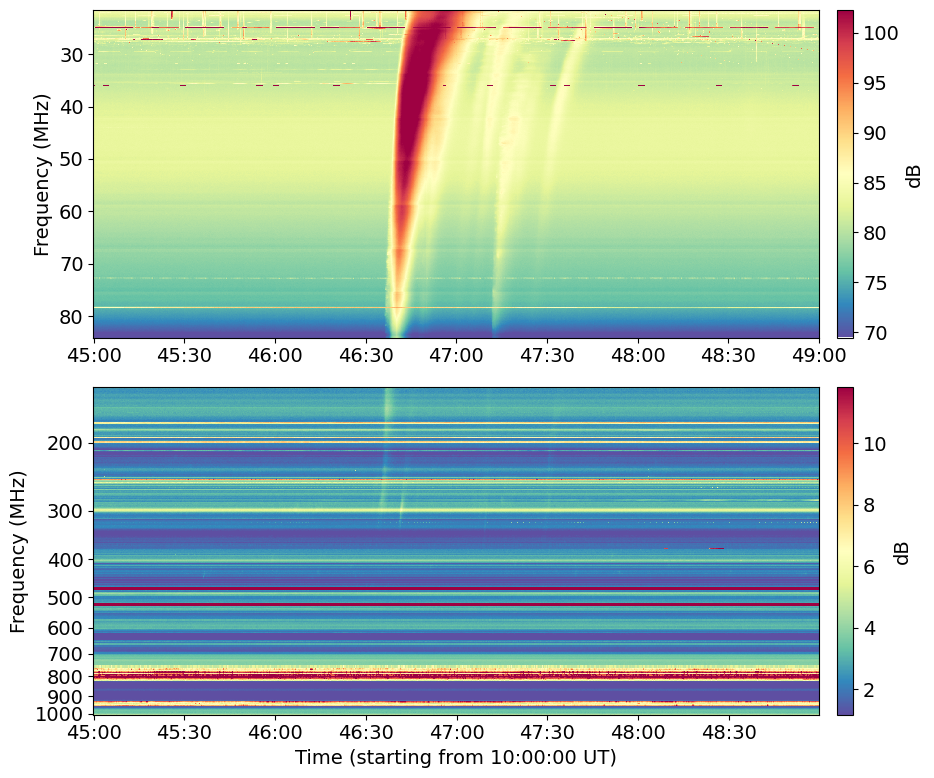

In [252]:
fig = plt.figure(figsize=[10,8])

v_range = np.nanpercentile(nenufar_db_down, [1, 99])
ax = fig.add_subplot(211)
pc = ax.pcolormesh(nenufar_db_down.index, nenufar_db_down.columns, nenufar_db_down.T,
                   vmin=v_range[0], vmax=v_range[1],
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

v_range = np.nanpercentile(subdf_orfees_db, [10, 97])
ax = fig.add_subplot(212)
pc = ax.pcolormesh(subdf_orfees_db.index, subdf_orfees_db.columns, subdf_orfees_db.T,
                   vmin=v_range[0], vmax=v_range[1],
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel(f'Time (MM:SS(starting from {nenufar_db_down.index[0].time().hour}:00:00 UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

fig.tight_layout()
plt.show()

In [153]:
# Remove constant background
df_orfees_1s_nobkg = df_orfees_1s - np.tile(np.mean(df_orfees_1s,0), (df_orfees_1s.shape[0],1))

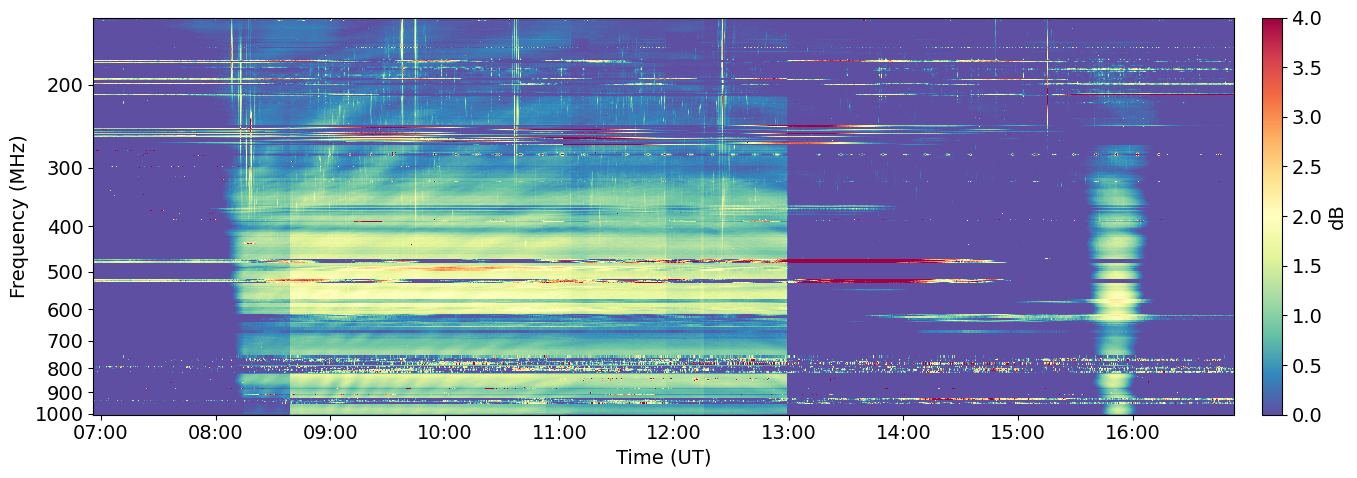

In [156]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s_nobkg.index, df_orfees_1s_nobkg.columns, df_orfees_1s_nobkg.T,
                   vmin=0, vmax=4, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [ ]:
# Interpolate NenuFAR onto ORFEES’s time grid
# This will interpolate each frequency column individually along the time axis
nenufar_on_orfees_time = nenufar_db_down.reindex(orfees_db.index).interpolate(method='time')

In [ ]:
nenufar_on_orfees_time.shape

In [181]:
# Step 1: Union of time indexes to safely interpolate
nenufar_union = nenufar_db_down.reindex(nenufar_db_down.index.union(orfees_db.index)).sort_index()

# Step 2: Interpolate NenuFAR values in time to fill in ORFEES timestamps
nenufar_interp = nenufar_union.interpolate(method='time')

# Step 3: Select only the rows that match ORFEES's time grid
nenufar_on_orfees_time = nenufar_interp.loc[orfees_db.index]

In [185]:
nenufar_on_orfees_time.shape

(358292, 10240)

In [186]:
orfees_db.shape

(358292, 998)

In [187]:
nenufar_on_orfees_time.head()

Frequency                21.582031  21.588135  21.594238  21.600342  \
2025-03-25 06:56:06.740        NaN        NaN        NaN        NaN   
2025-03-25 06:56:06.840        NaN        NaN        NaN        NaN   
2025-03-25 06:56:06.940        NaN        NaN        NaN        NaN   
2025-03-25 06:56:07.040        NaN        NaN        NaN        NaN   
2025-03-25 06:56:07.140        NaN        NaN        NaN        NaN   

Frequency                21.606445  21.612549  21.618652  21.624756  \
2025-03-25 06:56:06.740        NaN        NaN        NaN        NaN   
2025-03-25 06:56:06.840        NaN        NaN        NaN        NaN   
2025-03-25 06:56:06.940        NaN        NaN        NaN        NaN   
2025-03-25 06:56:07.040        NaN        NaN        NaN        NaN   
2025-03-25 06:56:07.140        NaN        NaN        NaN        NaN   

Frequency                21.630859  21.636963  ...  84.020996  84.027100  \
2025-03-25 06:56:06.740        NaN        NaN  ...        NaN        NaN   
2025-03-25 06:56:06.840        NaN        NaN  ...        NaN        NaN   
2025-03-25 06:56:06.940        NaN        NaN  ...        NaN        NaN   
2025-03-25 06:56:07.040        NaN        NaN  ...        NaN        NaN   
2025-03-25 06:56:07.140        NaN        NaN  ...        NaN        NaN   

Frequency                84.033203  84.039307  84.045410  84.051514  \
2025-03-25 06:56:06.740        NaN        NaN        NaN        NaN   
2025-03-25 06:56:06.840        NaN        NaN        NaN        NaN   
2025-03-25 06:56:06.940        NaN        NaN        NaN        NaN   
2025-03-25 06:56:07.040        NaN        NaN        NaN        NaN   
2025-03-25 06:56:07.140        NaN        NaN        NaN        NaN   

Frequency                84.057617  84.063721  84.069824  84.075928  
2025-03-25 06:56:06.740        NaN        NaN        NaN        NaN  
2025-03-25 06:56:06.840        NaN        NaN        NaN        NaN  
2025-03-25 06:56:06.940        NaN        NaN        NaN        NaN  
2025-03-25 06:56:07.040        NaN        NaN        NaN        NaN  
2025-03-25 06:56:07.140        NaN        NaN        NaN        NaN  

[5 rows x 10240 columns]